<a href="https://colab.research.google.com/github/ashleyliang08/Personal-Projects-links-to-my-resume/blob/main/%E6%B7%98%E5%AE%9D%E7%94%A8%E6%88%B7%E8%B4%AD%E7%89%A9%E8%A1%8C%E4%B8%BA%E5%88%86%E6%9E%90%EF%BC%88%E6%96%B0%EF%BC%89_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 淘宝用户购物行为分析

## Before Started

### （一）数据集说明


1.数据源
本项目数据来自阿里云天池实验室公开数据集User behavior data from Taobao for recommendation。原url：https://tianchi.aliyun.com/dataset/649

2.数据描述
原数据集包含了**2017年11月25日至2017年12月3日之间，约一百万随机用户、共计一亿多条行为数据（行为括点击、购买、加购、收藏）。**

共计5列字段，分别是：userid（用户ID）、itemid（商品ID）、categoryid（商品类目ID）、type（行为类型）timestamp（时间戳）。

用户行为类型共有四种，分别是：pv、buy、cart和fav。

数据集大小：用户数量987991，商品数量4161138，商品类目数量9437，所有行为数量100095231。

### （二）样本量说明

由于1亿的数据量实在太大，为了加快程序运行速度，采用**简单随机抽样**的方式完成特定时间内淘宝用户群体的购物行为分析。

我希望达到**95%的置信水平**并且控制**误差范围在1%**，假定**有潜在购买倾向的淘宝用户的行为占总体的45%**。

根据Cochran 公式：Z^2*p(1-p)/E^2,其中Z为95%置信水平下的z统计量，p为预期在总体中存在的属性比例，E为误差范围，计算得到n0≈9508。由于总体数量有限（N = 987991），采用有限总体修正公式n = n0/(1+(n0-1)/N)调整样本量，得到 **最终样本量大小为9417**。


## 导入库

In [ ]:
!pip install duckdb numpy pandas matplotlib seaborn
!pip install pyecharts
import duckdb
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,date
import pyecharts
import time

## 导入数据

In [ ]:
start = time.time()
duckdb.sql("""
DROP TABLE IF EXISTS tb_user_info;
CREATE TABLE tb_user_info
AS
SELECT * FROM read_csv("UserBehavior.csv",columns = {
"User_Id":'INT',
"Item_Id":'INT',
"Category_Id":'INT',
"Behavior_Type":'VARCHAR',
"Timestamp":'INT'},null_padding = True)
WHERE strftime(to_timestamp(Timestamp),'%Y-%m-%d') between '2017-11-25' and '2017-12-03';
DELETE FROM tb_user_info
WHERE User_Id is null
""")
print(f"读取数据所耗时间：{time.time()-start:.2f}秒")


读取数据所耗时间：8.55秒


In [ ]:
#检查数据是否导入-------成功
duckdb.sql("""
SELECT * FROM tb_user_info ORDER BY 1 LIMIT 5
""")


┌─────────┬─────────┬─────────────┬───────────────┬────────────┐
│ User_Id │ Item_Id │ Category_Id │ Behavior_Type │ Timestamp  │
│  int32  │  int32  │    int32    │    varchar    │   int32    │
├─────────┼─────────┼─────────────┼───────────────┼────────────┤
│       1 │ 2268318 │     2520377 │ pv            │ 1511544070 │
│       1 │ 2333346 │     2520771 │ pv            │ 1511561733 │
│       1 │ 2576651 │      149192 │ pv            │ 1511572885 │
│       1 │ 3830808 │     4181361 │ pv            │ 1511593493 │
│       1 │ 4365585 │     2520377 │ pv            │ 1511596146 │
└─────────┴─────────┴─────────────┴───────────────┴────────────┘

In [ ]:
duckdb.sql("""
SELECT
COUNT(DISTINCT User_Id) AS "用户",
COUNT(DISTINCT Item_Id) AS "商品条目",
COUNT(DISTINCT Category_Id)AS "商品种类",
COUNT(DISTINCT Behavior_Type) AS "行为类型",
COUNT(*) as "行为总数",
FROM tb_user_info
""")

┌────────┬──────────┬──────────┬──────────┬───────────┐
│  用户  │ 商品条目 │ 商品种类 │ 行为类型 │ 行为总数  │
│ int64  │  int64   │  int64   │  int64   │   int64   │
├────────┼──────────┼──────────┼──────────┼───────────┤
│ 987991 │  4161138 │     9437 │        4 │ 100095231 │
└────────┴──────────┴──────────┴──────────┴───────────┘

可以看到原数据集有一亿多条用户行为数据。经测试duckdb读取数据的速度（10s左右）较纯pandas读入要高出两倍以上（30s左右）。

## 随机抽样

In [ ]:
sample_df = duckdb.sql("""
SELECT * FROM tb_user_info
WHERE User_Id IN(
SELECT DISTINCT User_Id FROM tb_user_info
ORDER BY RANDOM()
LIMIT 9417
)
""").df()
print(f"抽样用户数：{sample_df['User_Id'].nunique()}")
print(f"抽样用户行为总数：{len(sample_df)}")
sample_df.tail()

抽样用户数：9417
抽样用户行为总数：952555


,User_Id,Item_Id,Category_Id,Behavior_Type,Timestamp
952550,99317,2360065,672001,pv,1511966270
952551,99317,4299936,2202384,pv,1512009353
952552,99317,2868004,2939262,pv,1512009375
952553,99317,1657429,3620161,pv,1512182551
952554,99317,1877073,3081594,pv,1512296541


## 数据准备

In [ ]:
###1.检查列缺失值-----显示没有缺失值
print(sample_df.isnull().value_counts())

User_Id  Item_Id  Category_Id  Behavior_Type  Timestamp
False    False    False        False          False        952555
Name: count, dtype: int64


In [ ]:
###2.检查异常值
#1)检查Timestamp是否存在负值------显示不存在负值
print("Timestamp：\n",sample_df[sample_df['Timestamp']<0])
sample_df = sample_df[sample_df['Timestamp']>0]
#2)检查Behavior_Type是否有异常值--------显示不存在异常值
print("\nBehavior_Type：\n",sample_df['Behavior_Type'].value_counts())

Timestamp：
 Empty DataFrame
Columns: [User_Id, Item_Id, Category_Id, Behavior_Type, Timestamp]
Index: []

Behavior_Type：
 Behavior_Type
pv      852213
cart     54050
fav      27055
buy      19237
Name: count, dtype: int64


In [ ]:
###3.将时间戳转化时间单位，结果显示时间范围在预期的2017-11-25至2017-12-03内
#--------因为是对淘宝用户购物行为分析，因此用pandas转化时间戳时，设定时区为东八区！
#--------也可以直接在duckdb中用strftime提前转换成Datetime/Date/Hour等列；
#--------因为经验证duckdb默认返回数据库服务器所在时区，而pandas默认返回utc时区。
sample_df['Datetime'] = pd.to_datetime(sample_df['Timestamp'],unit = 's',utc = True)\
    .dt.tz_convert('Asia/Shanghai')  ####重新设置为东八区！！！
sample_df['Date'] = sample_df['Datetime'].dt.date
sample_df['Hour'] = sample_df['Datetime'].dt.hour #提取小时
sample_df['Weekday'] = sample_df['Datetime'].dt.weekday #提取星期
sample_df['Weekday'] = sample_df['Weekday'] + 1 #设定 1= Monday,7 = Sunday
print(sample_df.head(),'\n')
#确保日期范围无误
print(sample_df['Date'].min(),sample_df['Date'].max())
print(sample_df['Date'].value_counts().sort_index())
print(sample_df['Date'].value_counts().sum())

   User_Id  Item_Id  Category_Id Behavior_Type   Timestamp  \
0    12350  4658411      2440115            pv  1511700075   
1    12350  3277946      4818107            pv  1511742254   
2    12350   729565      4818107            pv  1511742275   
3    12350  3277946      4818107            pv  1511742299   
4    12350  4289922      4818107          cart  1511742379   

                   Datetime        Date  Hour  Weekday  
0 2017-11-26 20:41:15+08:00  2017-11-26    20        7  
1 2017-11-27 08:24:14+08:00  2017-11-27     8        1  
2 2017-11-27 08:24:35+08:00  2017-11-27     8        1  
3 2017-11-27 08:24:59+08:00  2017-11-27     8        1  
4 2017-11-27 08:26:19+08:00  2017-11-27     8        1   

2017-11-25 2017-12-03
Date
2017-11-25     98792
2017-11-26    101320
2017-11-27     95864
2017-11-28     95804
2017-11-29     99625
2017-11-30     99085
2017-12-01    103209
2017-12-02    129316
2017-12-03    129540
Name: count, dtype: int64
952555


In [ ]:
#这是他人的做法，值得借鉴。
# data = sample_df.copy()
# data.loc[:,'Timestamp']=data['Timestamp'].apply(lambda x: time.strftime("%Y-%m-%d %H:%M:%S", ----注意这里
#                                                                     time.localtime(x)))
# data.loc[:,'Date']=data['Timestamp'].apply(lambda x:x.split(' ')[0])
# data.loc[:,'Time']=data['Timestamp'].apply(lambda x:x.split(' ')[1])

In [ ]:
###4.去除重复值
columns = sample_df.columns.tolist()
sample_df.drop_duplicates(subset = columns,keep = 'first',inplace = True)
print(sample_df.duplicated().value_counts())


False    952555
Name: count, dtype: int64


## 探索数据

In [ ]:
describe = pd.DataFrame({"用户数量":len(set(list(sample_df['User_Id']))),
                        "商品条目":len(set(list(sample_df['Item_Id']))),
                        "商品种类":len(set(list(sample_df['Category_Id']))),
                        "商品种类":len(set(list(sample_df['Category_Id']))),
                        "统计天数":len(set(list(sample_df['Date'])))},index = ['']
                       )
describe

,用户数量,商品条目,商品种类,统计天数
,9417,389812,5774,9


## 数据分析与可视化

### 用户流量分析

#### PART1.基于小时的流量分析

In [ ]:
hourly_uv_pv = sample_df.groupby('Hour').agg(
    PV = ('User_Id','count'),
    UV = ('User_Id','nunique')
)
# hourly_uv_pv

In [ ]:
sns.set_theme()
sns.set_context('notebook')

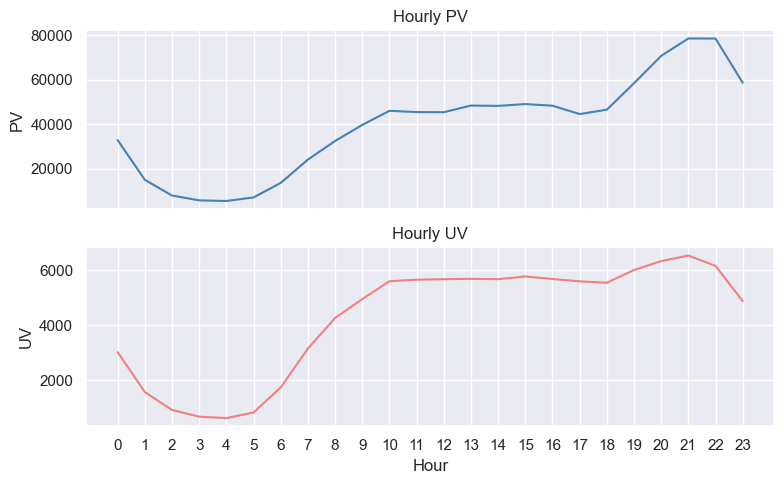

In [ ]:
plt.style.use('ggplot')
sns.set_theme()
fig,(ax1,ax2) = plt.subplots(2,1,sharex = True,figsize=(8, 5))
sns.lineplot(x = 'Hour',y = 'PV',data = hourly_uv_pv ,color = 'steelblue',ax = ax1)
ax1.set_title('Hourly PV')

sns.lineplot(x = 'Hour',y = 'UV',data = hourly_uv_pv ,color = 'lightcoral',ax = ax2)
ax2.set_title('Hourly UV')
hours = range(24)
ax2.set_xticks(hours)
ax2.set_xticklabels([f'{h}' for h in hours], rotation=0)
plt.tight_layout()
plt.show()



#### PART2.基于天的流量分析

In [ ]:
daily_uv_pv = sample_df.groupby('Date').agg(
    PV = ('User_Id','count'),
    UV = ('User_Id','nunique')
)
daily_uv_pv

,PV,UV
Date,,
2017-11-25,98792,6720
2017-11-26,101320,6839
2017-11-27,95864,6808
2017-11-28,95804,6797
2017-11-29,99625,6852
2017-11-30,99085,6984
2017-12-01,103209,7062
2017-12-02,129316,9257
2017-12-03,129540,9224


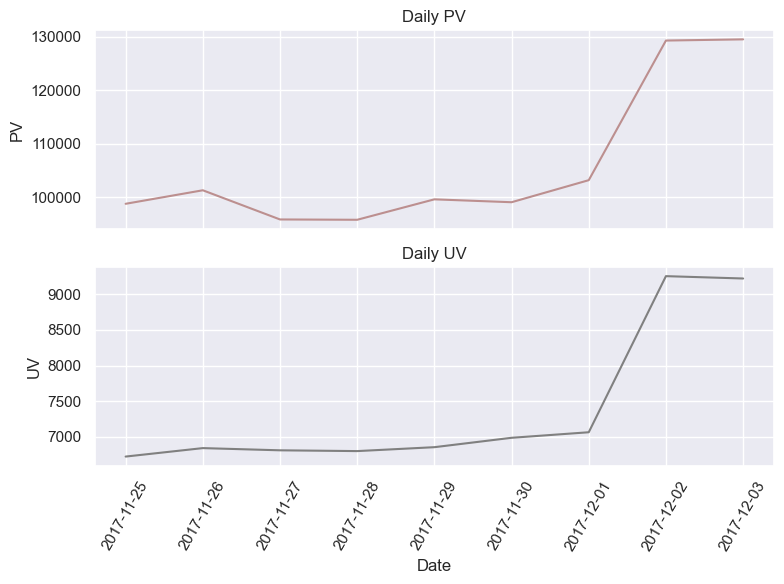

In [ ]:

sns.set_theme()
fig,(ax1,ax2) = plt.subplots(2,1,sharex = True,figsize=(8,6))
sns.lineplot(x = 'Date',y = 'PV',data = daily_uv_pv ,color = 'rosybrown',ax = ax1)
ax1.set_title('Daily PV')

sns.lineplot(x = 'Date',y = 'UV',data = daily_uv_pv ,color = 'grey',ax = ax2)
ax2.set_title('Daily UV')
dates = daily_uv_pv.index.tolist()
ax2.set_xticks(dates)
ax2.set_xticklabels(dates, rotation=60,ha = 'center')
plt.tight_layout()
plt.show()


In [ ]:
sample_df.head(2)

,User_Id,Item_Id,Category_Id,Behavior_Type,Timestamp,Datetime,Date,Hour,Weekday
0,12350,4658411,2440115,pv,1511700075,2017-11-26 20:41:15+08:00,2017-11-26,20,7
1,12350,3277946,4818107,pv,1511742254,2017-11-27 08:24:14+08:00,2017-11-27,8,1


#### 基于周末的流量分析

In [ ]:
weekly_uv_pv = sample_df.groupby('Weekday').agg(
    PV = ('User_Id','count'),
    UV = ('User_Id','nunique')
)


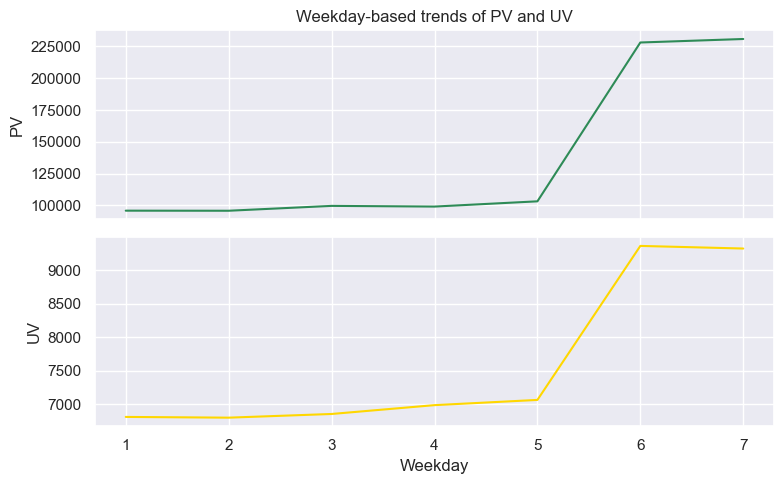

In [ ]:
# sns.set_theme()
fig,(ax1,ax2) = plt.subplots(2,1,sharex = True,figsize=(8,5))
sns.lineplot(x = 'Weekday',y = 'PV',data = weekly_uv_pv ,color = 'seagreen',ax = ax1)
ax1.set_title('Weekday-based trends of PV and UV')

sns.lineplot(x = 'Weekday',y = 'UV',data = weekly_uv_pv ,color = 'gold',ax = ax2)

weekdays = weekly_uv_pv.index.tolist()
ax2.set_xticks(weekdays)
ax2.set_xticklabels(weekdays, rotation=0,ha = 'center')
plt.tight_layout()
plt.show()

#### PART3.用户其他行为流量分析

##### 1）不同时段的点击、收藏、加购、购买行为流量分析

In [ ]:
hourly_behavior = sample_df.groupby(['Hour','Behavior_Type']).size().unstack()
hourly_behavior.head()

Behavior_Type,buy,cart,fav,pv
Hour,,,,
0,500,1836,983,29639
1,231,855,568,13502
2,135,438,267,7259
3,57,328,132,5398
4,72,359,135,5074


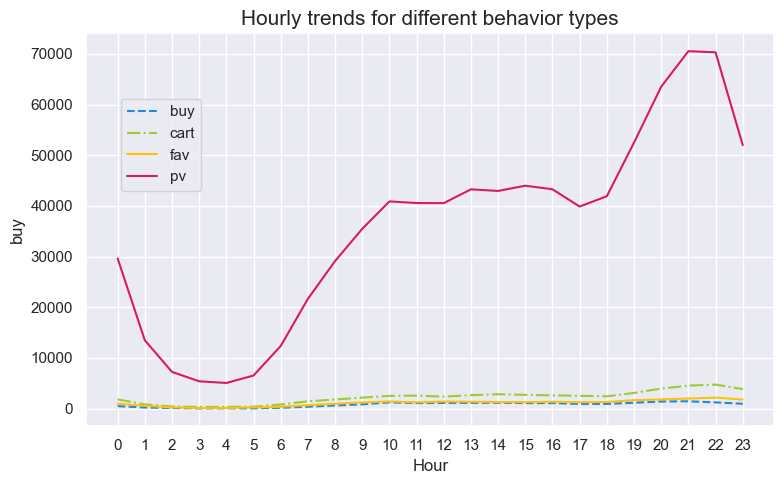

In [ ]:
plt.figure(figsize=(8, 5))
sns.set_theme()
color_list = ['#1E88E5','yellowgreen', '#FFC107','#D81B60']
linestyle_list = ['--','-.', '-', '-']
for i,behavior in enumerate(hourly_behavior.columns.tolist()):
    sns.lineplot(data=hourly_behavior, x='Hour',y = behavior,label =behavior,
                 linestyle=linestyle_list[i], color = color_list[i],err_style=None)

plt.legend(loc=(0.05,.6))
hours = range(24)
plt.xticks(hours)
plt.title('Hourly trends for different behavior types',fontsize = 15)
plt.tight_layout()
plt.show()

##### 2）总访问量与成交量时间变化分析（小时）

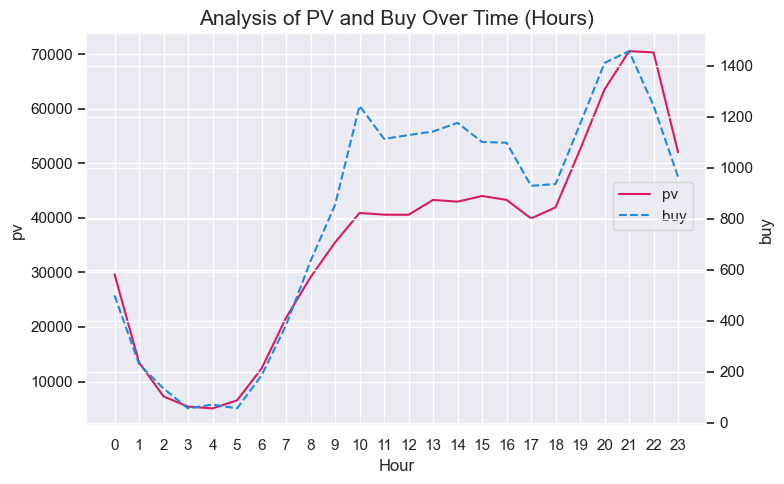

In [ ]:

# 筛选需要的行为列（保留 'pv' 和 'buy'）
behavior_cols = hourly_behavior.columns.tolist()
target_cols = [col for col in behavior_cols if col != 'cart' and col != 'fav']

# 创建画布和主坐标轴
fig, ax1 = plt.subplots(figsize=(8, 5))
sns.set_theme()
color_list = ['#1E88E5', '#D81B60']
linestyle_list = ['--', '-']

# 初始化副坐标轴
ax2 = None

# 循环处理每个行为
for i, behavior in enumerate(target_cols):
    # 第一个行为用主坐标轴（ax1）
    if i == 1:
        ax = ax1
        # 绘制线条
        sns.lineplot(
            data=hourly_behavior,
            x='Hour',
            y=behavior,
            label=behavior,
            linestyle=linestyle_list[i],
            color=color_list[i],
            ax=ax,
            err_style=None
        )
        # 配置主坐标轴样式
        ax.set_ylabel(behavior)
        ax.tick_params(axis='y', labelcolor='k')

    # 第二个行为用副坐标轴（ax2，共享x轴）
    else:
        ax2 = ax1.twinx()  # 创建副轴
        # 绘制线条
        sns.lineplot(
            data=hourly_behavior,
            x='Hour',
            y=behavior,
            label=behavior,
            linestyle=linestyle_list[i],
            color=color_list[i],
            ax=ax2,
            err_style=None,
            legend=False  # 副轴不单独显示图例
        )
        # 配置副坐标轴样式
        ax2.set_ylabel(behavior)
        ax2.tick_params(axis='y', labelcolor='k')

# 合并主副轴的图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels() if ax2 else ([], [])
ax1.legend(lines1 + lines2, labels1 + labels2, loc=(0.85, 0.50))

# 调整x轴和标题
hours = range(24)
ax1.set_xticks(hours)
ax1.set_xlabel('Hour')
plt.title('Analysis of PV and Buy Over Time (Hours)', fontsize=15)

plt.tight_layout()
plt.show()


### 用户行为分析

#### 漏斗模型(echart)

In [ ]:
#数据准备
behavior_data = pd.DataFrame(sample_df['Behavior_Type'].value_counts())
behavior_data.reset_index(inplace = True)
behavior_data.columns = ['Behavior','Numbers']
behavior_data.loc[1,'Behavior'] = 'cart+fav'
behavior_data.loc[1,'Numbers'] += behavior_data.loc[2,'Numbers']
behavior_data = behavior_data.loc[[0,1,3],:]
print(behavior_data)
print(behavior_data['Numbers'].sum())


   Behavior  Numbers
0        pv   852213
1  cart+fav    81105
3       buy    19237
952555


In [ ]:
# 计算单一环节转化率 = 后一个行为的次数 /前一个行为的次数
temp1 = np.array(behavior_data['Numbers'][1:])  ##后一个行为，从cart+fav（80710）开始到buy（19510）
temp2 = np.array(behavior_data['Numbers'][0:-1])  ##前一个行为，从pv（861393）开始，到倒数第二个cart+fav（80710）
single_convs = list(temp1 / temp2)
single_convs.insert(0,1) #pv环节的转化率应为1
single_convs = [round(x,4) for x in single_convs] ##保留四位小数
behavior_data['单一环节转化率'] = single_convs

# 计算总体转化率 = 当前行为的次数 / 初始行为（pv）的总次数
temp3 = np.array(behavior_data['Numbers']) #当前行为数组
temp4 = np.ones(len(behavior_data['Numbers'])) * behavior_data['Numbers'][0]  ##初始行为“pv”的数组
total_convs = list(temp3 / temp4)
total_convs = [round(x,4) for x in total_convs]
behavior_data['总体转化率'] = total_convs
print(behavior_data)


   Behavior  Numbers  单一环节转化率   总体转化率
0        pv   852213   1.0000  1.0000
1  cart+fav    81105   0.0952  0.0952
3       buy    19237   0.2372  0.0226


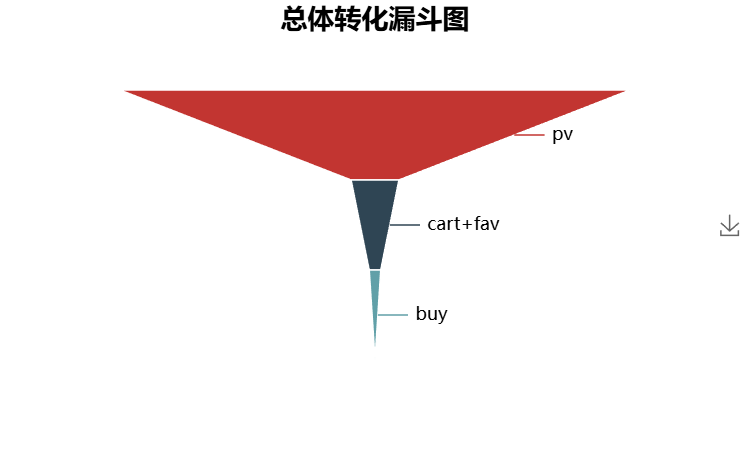

In [ ]:
#总体转化率可视化
from pyecharts import Funnel
attrs = behavior_data['Behavior'].tolist()
attr_value = (np.array(behavior_data['总体转化率'])*100).tolist()

funnel = Funnel('总体转化漏斗图',width = 500,height = 300,title_pos = 'center')
funnel.add(name = '商品交易环节',   #指定图例名称
          attr = attrs,            # 指定属性名称
          value = attr_value,      # 指定属性所对应的值
          is_label_show = True,    # 指定标签是否显示
          label_formatter = '{b}:{c}%',  # 指定标签显示的格式
          label_pos = 'outside',         # 指定标签的位置
          is_legend_show = False)        # 指定图例不显示图例

from IPython.display import Image as IMG

display(IMG("总体转化率.png"))



### 用户特征分析

#### RMF用户分层分析（基于购买行为）

RFM模型即"R"——Recency（最近一次消费时间）、"F"——Frequency（一段时间内消费频次）、"M"——（一段时间内消费总额）。这三个指标可以将我们的用户划分成不同的等级和层次，目的是为了衡量他们的用户价值，从而能够更准确地将成本和精力花在更精确的用户层次身上。这里没有关于金额的数据，因此只进行RF分析。


In [ ]:
#  1. 计算用户级的RMF指标
# 筛选购买数据
buy_data = sample_df[sample_df['Behavior_Type'] == 'buy'].copy()
# 确保日期是datetime类型
buy_data['Date'] = pd.to_datetime(buy_data['Date'])
# 分析截止日期
last_date = pd.to_datetime('2017-12-03')
# 按用户分组，计算：
# 1)Recency：用户最近一次购买的间隔（取用户最大日期计算）
# 2)Frequency：用户总购买次数
user_rmf = buy_data.groupby('User_Id').agg(
    Recency=('Date', lambda x: (last_date - x.max()).days),  # 最近一次购买的间隔（用户级）
    Frequency=('Behavior_Type', 'count')  # 总购买次数（用户级）
).reset_index()

# 2. 划分用户级的R/F高低和RMF分类-
# 计算中位数
r_median = user_rmf['Recency'].median()
f_median = user_rmf['Frequency'].median()
print(r_median)
print(f_median)
# 划分R/F高低（用户级，每个用户唯一）
user_rmf['R'] = user_rmf['Recency'].apply(lambda x: '高' if x <= r_median else '低')
user_rmf['F'] = user_rmf['Frequency'].apply(lambda x: '高' if x >= f_median else '低')

# 定义RMF分类函数（用户级）
def rmf(recency, frequency):
    if recency == '高' and frequency == '高':
        return "价值用户"
    elif recency == '高' and frequency == '低':
        return "发展客户"
    elif recency == '低' and frequency == '高':
        return "保持客户"
    else:
        return "挽留客户"

# 每个用户唯一的RMF分类
user_rmf['RMF'] = user_rmf.apply(lambda row: rmf(row['R'], row['F']), axis=1)

rf_data = buy_data.merge(user_rmf, on='User_Id', how='left')
rf_data.head()


2.0
2.0


,User_Id,Item_Id,Category_Id,Behavior_Type,Timestamp,Datetime,Date,Hour,Weekday,Recency,Frequency,R,F,RMF
0,12350,2795442,1474371,buy,1511743401,2017-11-27 08:43:21+08:00,2017-11-27,8,1,0,2,高,高,价值用户
1,12350,2813216,420556,buy,1512265807,2017-12-03 09:50:07+08:00,2017-12-03,9,7,0,2,高,高,价值用户
2,123714,1937071,4789432,buy,1511775754,2017-11-27 17:42:34+08:00,2017-11-27,17,1,1,17,高,高,价值用户
3,123714,1097899,1051370,buy,1511775754,2017-11-27 17:42:34+08:00,2017-11-27,17,1,1,17,高,高,价值用户
4,123714,1097899,1051370,buy,1511790661,2017-11-27 21:51:01+08:00,2017-11-27,21,1,1,17,高,高,价值用户


通过RMF模型，根据业务对最近一次消费时间和消费频率数据进行对用户进行打分。根据高低值打分，将用户分为价值用户、发展用户、保持用户和挽留用户四种，并对不同类别的用户占比进行分析，从而实现差异化营销。

In [ ]:
# 去重：每个用户只保留一条记录
user_rmf.drop_duplicates(subset  = ['User_Id'],inplace = True)
# 统计各类别用户数量和占比
rmf_counts = user_rmf['RMF'].value_counts()
rmf_ratio = rmf_counts / rmf_counts.sum()

print("各分层用户数量：")
print(rmf_counts)
print("\n各分层用户占比：")
print(rmf_ratio.round(4) * 100)  # 百分比

各分层用户数量：
RMF
价值用户    2832
保持客户    1410
挽留客户    1357
发展客户     840
Name: count, dtype: int64

各分层用户占比：
RMF
价值用户    43.98
保持客户    21.90
挽留客户    21.07
发展客户    13.05
Name: count, dtype: float64


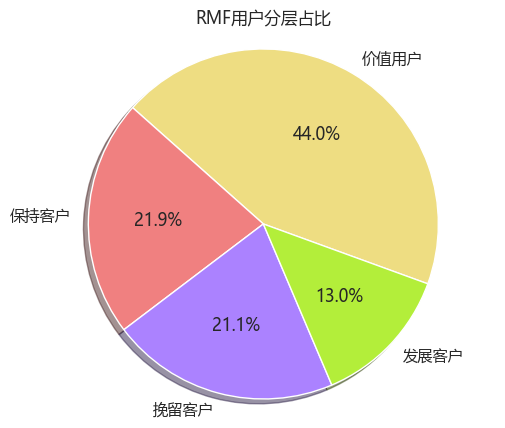

In [ ]:
# 2.可视化
plt.rcParams["font.family"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False

labels = rmf_counts.index
sizes = rmf_counts.values

plt.figure(figsize=(6, 5))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=["#EEDD82", "#F08080", "#AB82FF", "#B3EE3A"],
    shadow=True,
    startangle=-20
)

plt.axis('equal')
plt.title('RMF用户分层占比')
plt.show()

### 留存复购率

### 商品分析